# Cooling of the oceanic lithosphere

**Goal:** Implement the half-space cooling model and compare its predictions to observations of heat flow, lithosphere age, and bathymetry.

The half-space cooling model simulates the cooling of the oceanic lithosphere as it moves away from the mid-ocean ridges where it's formed (due to  seafloor spreading).

<img style="width: 700px; margin: 10px auto;" src="https://raw.githubusercontent.com/leouieda/lithosphere/bb86251c0934b0df98c32181788fdc76472aa4b5/lectures/assets/halfspace-model-time.svg">
<p style="text-align: left; width: 700px; max-width: 100%; margin: 30px auto;">
Figure caption: Sketch of the half-space cooling model setup. The lithosphere-asthenosphere boundary (LAB) is marked by an isotherm. The ridge is at the origin and the plates spread symmetrically with constant velocity $u$.
</p>

The cooling happens by vertical condution of heat to the water layer and can be modelled by the 1D diffusion equation:

$$
\dfrac{\partial^2 T}{\partial z^2}
= \dfrac{1}{\alpha} \dfrac{\partial T}{\partial t}
$$


The solution to this equation, given the starting condition of the temperature being equal to the asthenosphere temperature $T(z, t=0) = T_a$ and boundary condition of the temperature at the surface being constant $T(z=0, t) = T_0$, is:

$$
T(z, t) = T_0 + (T_a - T_0)\ \text{erf}
\left(
\dfrac{z}{2\sqrt{\alpha t}}
\right)
$$

in which $\alpha$ is the thermal diffusivity of the lithosphere, $t$ is the age of the lithosphere, $z$ is the depth, and $\text{erf}$ is the error function.

From this equation, we can apply Fourier's law to get **heat flow at the surface**:

$$
\ q_0(t) = k \dfrac{T_a - T_0}{\sqrt{\pi \alpha t}}
$$

where $k$ is the thermal conductivity of the lithosphere.

We can also apply the conditions for isostatic equilibrium (since we know that the oceanic lithosphere is largely in equilibrium from gravity disturbance data) to predict **bathymetry** from the half-space cooling model:

$$
w(t) = w_r + \dfrac{2 \rho_a \alpha_V (T_a - T_0)}{\rho_a - \rho_w}
\sqrt{\dfrac{\alpha t}{\pi}}
$$

in which $w_r$ is the bathymetric depth at the ridge, $\rho_a$ is the density of the asthenosphere, $\rho_w$ is the density of water, and $\alpha_V$ is the coefficient of thermal expansion of the lithosphere.

**Our job now is to code the equations for bathymetry and surface heat flow in Python**.

## The data

**Download:** [global-geophysical-data.nc](https://github.com/leouieda/lithosphere/raw/main/data/global-geophysical-data.nc) (place it in the **same folder** as this notebook)

The data grids are stored in a [netCDF](https://en.wikipedia.org/wiki/NetCDF) file, which is a very common standard for storing and distributing gridded data. It's used throughout the Earth, ocean, and climate sciences and can be read an manipulated with most software platforms. It contains global grids of gravity, topography, and heat flow. All grids were interpolated onto the same resolution of 0.2 degrees (a compromise between resolution and size of the file) so that we can easily compare and use all of the data together.

* **Gravity**: generated from the [EIGEN-6C4 spherical harmonic model](https://doi.org/10.5880/icgem.2015.1) through the [ICGEM webservice](http://icgem.gfz-potsdam.de/home). It includes two grids: the gravity disturbance calculated with the WGS84 ellipsoid and the Bouguer gravity disturbance calculated using a topography density of 2670 kg/m³. The data for both grids was generated on top of the Earth's surface (the water surface in the oceans and topography on land).
* **Topography and bathymetry**: a downsampled version of [ETOPO1](https://doi.org/10.7289/V5C8276M) and includes a version smoothed using a Gaussian filter with 1 degree width (~100 km).
* **Heat flow**: an upsampled version of the compilation by [Lucazeau (2019)](https://doi.org/10.1029/2019GC008389) (originally 0.5 degree resolution).
* **Lithosphere age (oceanic)**: a downsampled version of the grid by [Müller et al. (2008)](https://doi.org/10.1029/2007GC001743) (originally 6 arc-minutes).

## Import the required libraries

Load the required software to load the data, make maps, and perform calculations.

In [1]:
# For arrays and linear algebra
import numpy as np
# To make figures and maps
import matplotlib.pyplot as plt
# To load and manipulate grids
import xarray as xr

## Load the data grids

Once again, we'll use xarray to load the data from the netCDF file.

In [4]:
data = xr.load_dataset("global-geophysical-data.nc")
data

<xarray.Dataset>
Dimensions:              (latitude: 901, longitude: 1800)
Coordinates:
  * latitude             (latitude) float32 -90.0 -89.8 -89.6 ... 89.6 89.8 90.0
  * longitude            (longitude) float32 -180.0 -179.8 ... 179.6 179.8
    height               (latitude, longitude) float32 2.716e+03 ... 15.47
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -27.21 -27.21 ... 24.71
    gravity_bouguer      (latitude, longitude) float32 -331.2 -331.2 ... 312.6
    topography_smoothed  (latitude, longitude) float32 2.796e+03 ... -3.56e+03
    topography           (latitude, longitude) float32 2.716e+03 ... -4.213e+03
    heat_flow            (latitude, longitude) float32 75.2 75.2 ... 84.7 84.7
    lithosphere_age      (latitude, longitude) float32 nan nan ... 55.46 55.46

For this practical, we'll use a subsection of the grid that overlaps with a mid-ocean ridge in the South Pacific (a large section around the island of [Rapa Nui](https://en.wikipedia.org/wiki/Easter_Island)).

In [180]:
pacific = data.sel(longitude=slice(-170, -80), latitude=slice(-70, -10))
#pacific = data.sel(longitude=slice(-30, 5), latitude=slice(-50, 0))
pacific 

<xarray.Dataset>
Dimensions:              (latitude: 301, longitude: 451)
Coordinates:
  * latitude             (latitude) float32 -70.0 -69.8 -69.6 ... -10.2 -10.0
  * longitude            (longitude) float32 -170.0 -169.8 ... -80.2 -80.0
    height               (latitude, longitude) float32 -62.98 -63.0 ... -0.5685
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -62.59 -58.97 ... -130.9
    gravity_bouguer      (latitude, longitude) float32 227.7 226.6 ... 190.4
    topography_smoothed  (latitude, longitude) float32 -4.17e+03 ... -3.21e+03
    topography           (latitude, longitude) float32 -4.247e+03 ... -4.702e+03
    heat_flow            (latitude, longitude) float32 61.8 61.8 ... 67.9 67.9
    lithosphere_age      (latitude, longitude) float32 74.22 74.19 ... 41.2 nan

We can now plot the observed heat flow, bathymetry, and lithospheric age to see what that looks like.

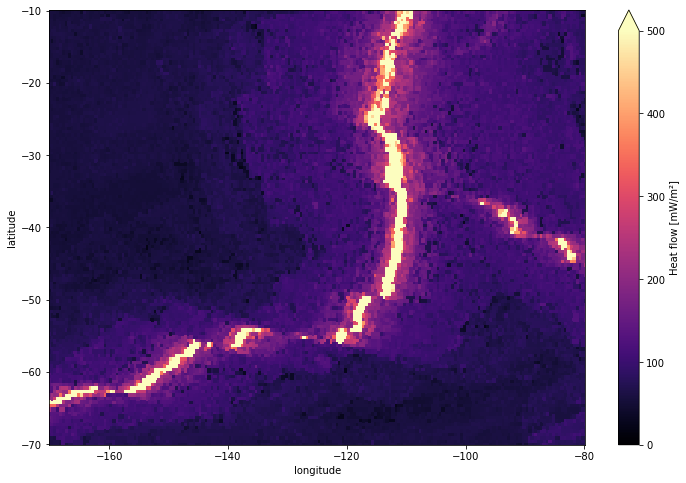

In [198]:
pacific.heat_flow.plot(figsize=(12, 8), vmin=0, vmax=500, cmap="magma")

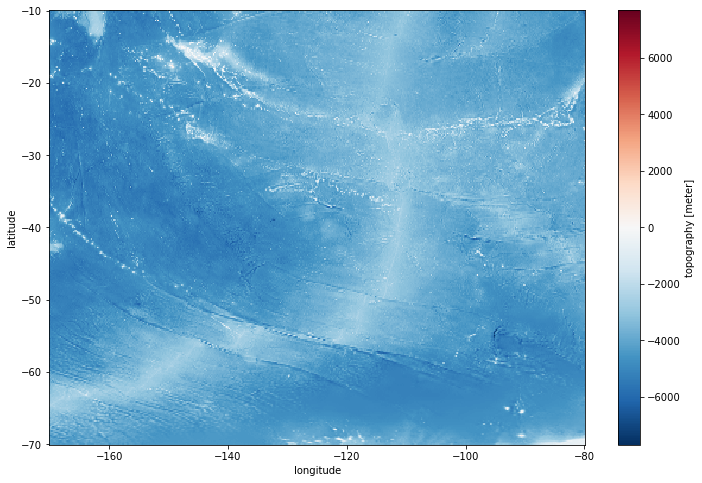

In [196]:
pacific.topography.plot(figsize=(12, 8))

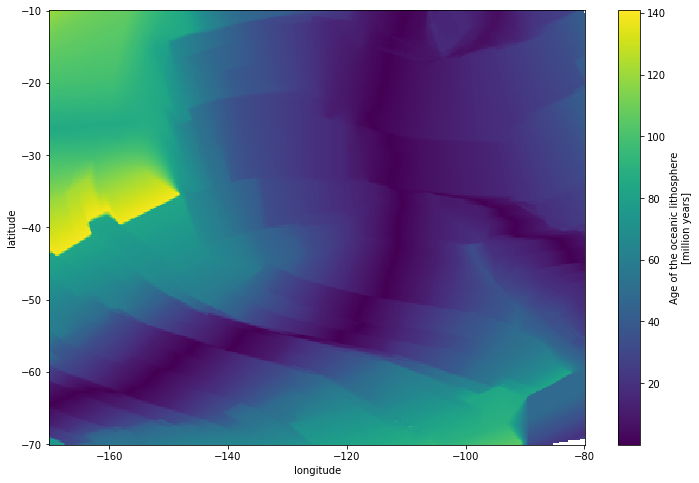

In [197]:
pacific.lithosphere_age.plot(figsize=(12, 8))

Another useful visualization is to plot lithosphere age versus bathymetry and heat flow. This is the relationship that we'll be predicting from our half-space cooling model so let's plot it and see what the data look like.

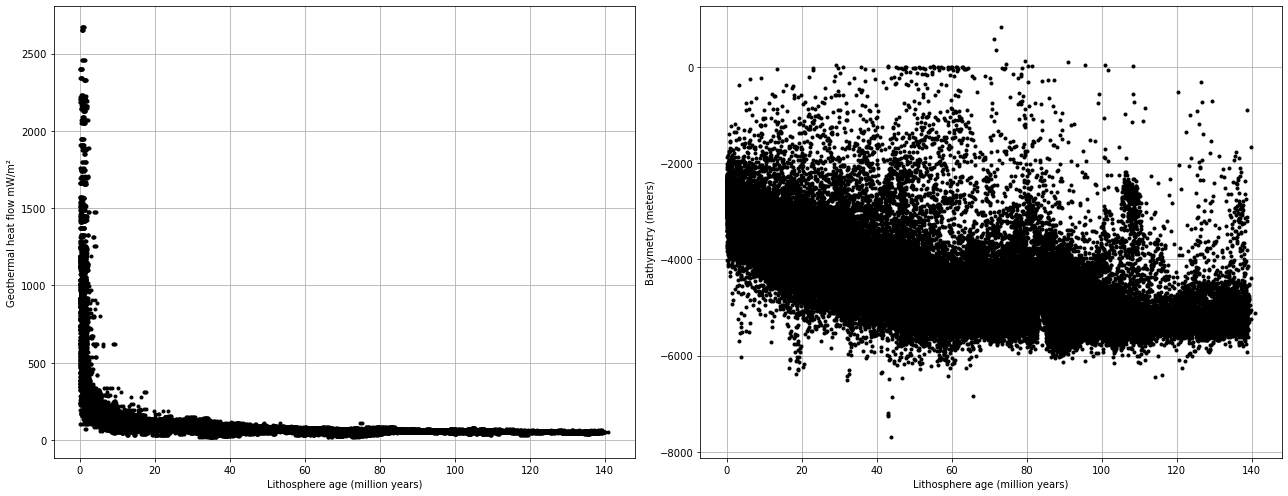

In [207]:
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.plot(pacific.lithosphere_age.values.ravel(), pacific.heat_flow.values.ravel(), ".k")
plt.xlabel("Lithosphere age (million years)")
plt.ylabel("Geothermal heat flow mW/m²")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(pacific.lithosphere_age.values.ravel(), pacific.topography.values.ravel(), ".k")
plt.xlabel("Lithosphere age (million years)")
plt.ylabel("Bathymetry (meters)")
plt.grid()
plt.tight_layout()

## Heat flow from half-space cooling

In [212]:
def halfspace_heat_flow(age, surface_temperature, asthenosphere_temperature, diffusivity, conductivity):
    """
    Heat flow from the half space cooling model.
    
    Parameters
    ----------
    age
        Lithosphere age in million years.
    surface_temperature
        Temperature of the surface boundary condition in K. 
    asthenosphere_temperature
        Temperature of the asthenosphere used as an initial condition in K.
    diffusivity
        Thermal diffusivity in mm²/s.
    conductivity
        Thermal conductivity in W/mK.
    
    Returns
    -------
    heat_flow
        Model heat flow at the surface in mW/m².
    """
    # 1000 converts from W to mW (miliWatts)
    # 1e-6 converts from mm² to m²
    myr_to_s = 1e6 * 365.25 * 24 * 60 * 60
    flow = 1000 * conductivity * (asthenosphere_temperature - surface_temperature) / (
        np.sqrt(np.pi * 1e-6 * diffusivity * age * myr_to_s)
    )
    return flow

In [214]:
predicted_heat_flow = halfspace_heat_flow(
    pacific.lithosphere_age, 
    surface_temperature=273, 
    asthenosphere_temperature=1600, 
    diffusivity=1, 
    conductivity=3.3
)

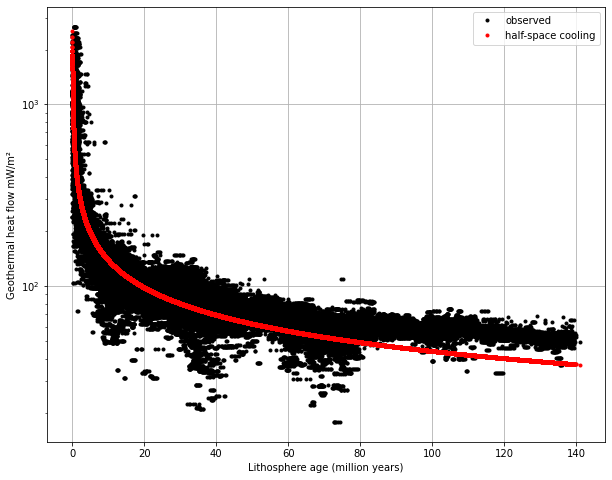

In [219]:
plt.figure(figsize=(10, 8))
plt.plot(pacific.lithosphere_age.values.ravel(), pacific.heat_flow.values.ravel(), ".k", label="observed")
plt.plot(pacific.lithosphere_age.values.ravel(), predicted_heat_flow.values.ravel(), ".r", label="half-space cooling")
plt.legend()
plt.yscale("log")
plt.xlabel("Lithosphere age (million years)")
plt.ylabel("Geothermal heat flow mW/m²")
plt.grid()

In [220]:
def halfspace_bathymetry(
    age, ridge_depth, density_mantle, density_water, surface_temperature, asthenosphere_temperature, 
    thermal_expansion, diffusivity
):
    "Predict bathymetry from the half-space cooling model"
    myr_to_s = 1e6 * 365.25 * 24 * 60 * 60
    bathymetry = (
        # Convert from km to m
        ridge_depth * 1e3
        + 2 * density_mantle * thermal_expansion * (asthenosphere_temperature - surface_temperature) / (
            density_mantle - density_water
            # Convert diffusivity from mm²/s to m²/s
        ) * np.sqrt(diffusivity * 1e-6 *  age * myr_to_s / np.pi)
    )
    # -1 because the equation gives us thickness of the water layer
    return -1 * bathymetry    

In [189]:
pacific_coarse = pacific.coarsen(longitude=6, latitude=6, boundary="trim").median()
pacific_coarse

<xarray.Dataset>
Dimensions:              (latitude: 50, longitude: 75)
Coordinates:
  * latitude             (latitude) float32 -69.5 -68.3 -67.1 ... -11.9 -10.7
  * longitude            (longitude) float32 -169.5 -168.3 ... -81.9 -80.7
    height               (latitude, longitude) float32 -62.09 -61.74 ... 1.593
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -63.41 -66.44 ... -10.5
    gravity_bouguer      (latitude, longitude) float32 226.4 230.2 ... 299.5
    topography_smoothed  (latitude, longitude) float32 -4.169e+03 ... -4.453e+03
    topography           (latitude, longitude) float32 -4.249e+03 ... -4.645e+03
    heat_flow            (latitude, longitude) float32 62.45 106.8 ... 83.1
    lithosphere_age      (latitude, longitude) float32 74.11 29.46 ... 40.39

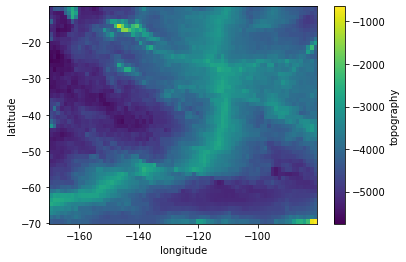

In [190]:
pacific_coarse.topography.plot()

In [191]:
bathy_halfspace = bathymetry_halfspace(
    pacific_coarse.lithosphere_age,
    ridge_depth=2.5,
    density_mantle=3300,
    density_water=1000,
    temperature_mantle=1600,
    temperature_surface=273,
    thermal_expansion=3e-5,
    diffusivity=1,
)

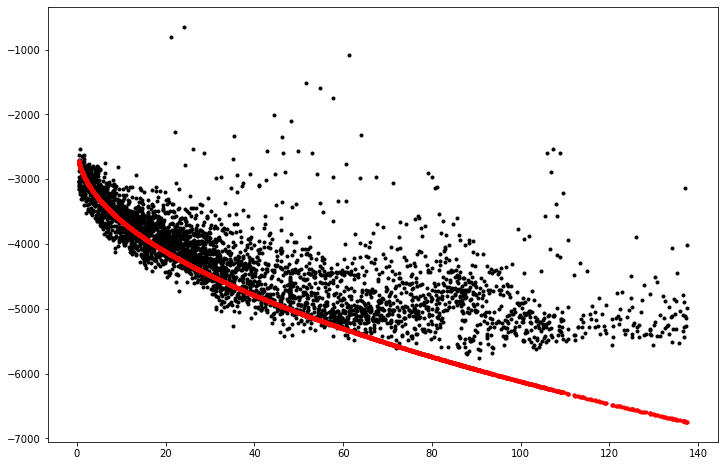

In [192]:
plt.figure(figsize=(12, 8))
plt.plot(pacific_coarse.lithosphere_age.values.ravel(), pacific_coarse.topography.values.ravel(), ".k")
plt.plot(pacific_coarse.lithosphere_age.values.ravel(), bathy_halfspace.values.ravel(), ".r")
